# Lab1 

TODO : Intro

## Step1 :  read the text file

In [22]:
#import nltk #Download word data uncomment and launch if you don't have the word data on your computer
#nltk.download()

In [4]:
from nltk.corpus import words #Import word data
word_list = words.words()
# prints 236736
print (len(word_list))
print (word_list[:100])

236736
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally', 'abaction', 'abactor', 'abaculus', 'abacus', 'Abadite', 'abaff', 'abaft', 'abaisance', 'abaiser', 'abaissed', 'abalienate', 'abalienation', 'abalone', 'Abama', 'abampere', 'abandon', 'abandonable', 'abandoned', 'abandonedly', 'abandonee', 'abandoner', 'abandonment', 'Abanic', 'Abantes', 'abaptiston', 'Abarambo', 'Abaris', 'abarthrosis', 'abarticular', 'abarticulation', 'abas', 'abase', 'abased', 'abasedly', 'abasedness', 'abasement', 'abaser', 'Abasgi', 'abash', 'abashed', 'abashedly', 'abashedness', 'abashless', 'abashlessly', 'abashment', 'abasia', 'abasic', 'abask', 'Abassin', 'abastardize', 'abatable', 'abate', 'abatement', 'abater', 'abatis', 'abatised', 'abaton', 'abator', 'abatt

In [5]:
import re
from math import log

def readAFile(file_name):
    text_file = open(file_name, "r", encoding="utf8")
    next(text_file) #Pass the first line
    lines = text_file.read().splitlines() #Contains raw lines
    dataset = []; #List of tuple (note, list of word)
    
    for line in lines :
        line = re.sub('\?|\!|\/|\;|\:|<br|>|\,|\"|[()]|<p', '', line.lower())
        #print(line)
        current_elt = line.split()
        note = 1 if (float(current_elt[-1]) > 3.0) else 0  
        list_of_words = []
        for word in current_elt[1:-1] :
            word = re.sub('\.','',word)
            list_of_words.append(word)
        dataset.append((note,list_of_words))
    text_file.close()
    return dataset

training_set = readAFile("lab_train.txt")


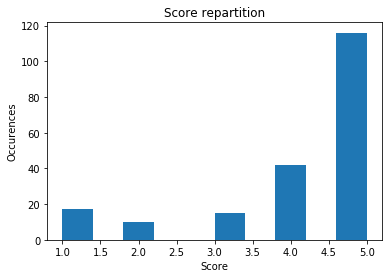

In [34]:
import matplotlib.pyplot as plt

def get_score(file_name):
    text_file = open(file_name, "r", encoding="utf8")
    next(text_file) #Pass the first line
    lines = text_file.read().splitlines() 
    scores = []
    
    for line in lines :
        line = re.sub('\?|\!|\/|\;|\:|<br|>|\,|\"|[()]|<p', '', line.lower())
        current_elt = line.split()
        score = float(current_elt[-1])  
        scores.append(score)
    text_file.close()
    return scores

scores = get_score("lab_train.txt")

plt.hist(scores)
plt.title("Score repartition")
plt.xlabel("Score")
plt.ylabel("Occurences")
plt.show()

In [35]:
#Add special words from training data into dictionnary
for data in training_set:
    for word in data[1]:
        word_list.append(word)
words = set(word_list)

print (len((words)))


238581


## Step2 : Generate the priors probabilities

We will then generate a dictionnary that contains the number of occurences of a word $d_i$ in class $C$

In [15]:
def getCountTable(dataset):
    count_table = {}
    for data in dataset:
        current_class = data[0]
        if (current_class not in count_table):
            count_table[current_class]={}
        for word in data[1]:
            if (word in count_table[current_class]):
                count_table[current_class][word]+=1
            else :
                 count_table[current_class][word]=1
    return count_table
count_table = getCountTable(training_set)

def getConditionalProbabilities(countTable,dataset,wordList):
    condprob = {}
    totalSum = {}
    for Classe in count_table :
        totalSum[Classe] = 0
        for word in countTable[Classe]:
            totalSum[Classe] += (countTable[Classe][word])
        current_class = Classe
        if (current_class not in condprob):
            condprob[current_class]={}
        for word in wordList:
            if (word in countTable[current_class]):
                condprob[current_class][word] = (countTable[current_class][word]+1)/(totalSum[current_class]+len(wordList))
            else :
                condprob[current_class][word] = (1)/(totalSum[current_class]+len(wordList))

    return condprob
condprob = getConditionalProbabilities(count_table,training_set,word_list)

            

We then need to calculate the probabilities of a given class $P(C)$ and $N_C$ the total number of words in class $C$

In [16]:
def getClassProbabilities(dataset): #Number of docs in class / total number of doc
    number_of_data = len(dataset)
    result = {}
    #Count all occurence of each class
    for data in dataset:
        current_class = data[0]
        if (current_class in result):
            result[current_class]+=1
        else :
            result[current_class]=1
    #Divide by the total number to get a probability
    for Class in result:
        result[Class] = float(result[Class])/number_of_data            
    return result

P_C = getClassProbabilities(training_set)
print(P_C)

{0: 0.21, 1: 0.79}


In our example we have $ P(1) = 0.5637877504939317 $ and $P(0) = 0.4362122495060683$

## Step 3 : Try the classifier

The probability of a document belongs to a class $C$ is given by
$$P \propto P(C) \cdot \prod_i P(d_i|C) = P(C) \cdot \prod_i^n \frac{count(d_i, C)}{\sum_j count(d_j, C)} = P(C) \cdot \prod_i \frac{count(d_i, C)}{N_C} $$
If we don't have any probability for the word $d_i$, we use $P(d_i|C) =1$ That is called the **Laplacian Smoothing**

As we don't normalize our probability we will compare $\ln(P(C)) + \sum_i \ln P(d_i | C) = \ln(P(C))-n\ln(N_C) + \sum_i \ln( count(d_i , C)) $

### 3.1 Get the test dataset

In [17]:

test_dataset = readAFile("lab_test.txt")
print(test_dataset[0])

(1, ['i', 'thank', 'the', 'lord', 'for', 'this', 'dvd', 'and', 'movieit', 'has', 'touched', 'my', 'life', 'down', 'through', 'the', 'yearsin', 'fact', 'when', 'i', 'was', 'in', 'a', 'car', 'accident', 'i', 'was', 'playing', 'the', 'music', 'from', 'this', 'movie', 'on', 'an', '8', 'track', 'tape', 'and', 'it', 'was', 'a', 'blessing', 'as', 'i', 'was', 'hit', 'and', 'in', 'a', 'ditchthe', 'song', 'was', "playingit's", 'a', 'miracle', 'and', 'it', 'wasthank', 'you'])


### 3.2 Choose according to the Naïve Bayes Classifier

In [18]:
def get_max_value_key(dictionnary):
    values = list(dictionnary.values())
    keys = list(dictionnary.keys())
    max_value_index = values.index(max(values))
    max_key = keys[max_value_index]
    return max_key

def classify(list_of_word):
    prediction = {}
    for Classe in condprob :
        nb_word_counted = 0
        prediction[Classe] = log(P_C[Classe]) #Initialisation 
        for word in list_of_word :
            if (word in condprob[Classe]):
                prediction[Classe] += log(condprob[Classe][word])

    return get_max_value_key(prediction)

index_to_try = 5
print(classify(test_dataset[index_to_try][1]))
print(' '.join(test_dataset[index_to_try][1]))
print("Real class : ",test_dataset[index_to_try][0])
            


1
this set for my husband's birthday we'd never really been able to get into the show while it ran but having the complete series - great idea content sg-1 is just great characters plots even an occasional effect product first order - lots of scratched disks several unplayable plenty of skipping and popping second order - just like first order 3 disks either totally or partially unplayable in first 5 seasons didn't bother checking rest returned this production quality is really unacceptable imo i don't care much about the price - having unplayable disks repeatedly points to a problem somewhere in the mfg or delivery chain amazon's response support first time issued replacements even though outside the 30 day window second time issued rma and full refund this was absolutely the right service response and my happiness with amazon went up several notches i may never buy another complete series boxed set without waiting and researching but i'll be back to amazon if only for the great servi

If we try to display all the test data :

In [19]:
for data in test_dataset:
    choosen_class = classify(data[1])
    print("----------------------------------")
    print(' '.join(data[1]))
    if (choosen_class==1) :
        print(choosen_class,"- Positive")
    else :
        print(choosen_class,"- Negative")
    print("True class :",data[0])
    

----------------------------------
i thank the lord for this dvd and movieit has touched my life down through the yearsin fact when i was in a car accident i was playing the music from this movie on an 8 track tape and it was a blessing as i was hit and in a ditchthe song was playingit's a miracle and it wasthank you
1 - Positive
True class : 1
----------------------------------
chance meeting on a train changes the life of tennis player guy haines farley granger in ways he never could have imagined when an odd obsessed tennis fan bruno anthony robert walker recognizes haines he does his best to ingratiate himself talking incessantly about the details of guy's life details that most people wouldn't bring up at first meeting but bruno is a strange man indeed bruno hates his father and wants him dead guy wants a divorce from his unfaithful wife miriam so he can marry political socialite ann morton ruth roman bruno devises a plan where he and guy swap or exchange murders guy murders bruno

In [20]:
error = 0
for data in test_dataset:
    choosen_class = classify(data[1])
    if (int(choosen_class) != int(data[0])):
        error +=1
print ("Test:" ,error," error over ",len(test_dataset)," data")

Test: 21  error over  100  data


In [21]:
error = 0
for data in training_set:
    choosen_class = classify(data[1])
    if (int(choosen_class) != int(data[0])):
        error +=1
print ("Training:",error," error over ",len(training_set)," data")

Training: 42  error over  200  data


In [37]:
#Booking dataset
ext_file = open("test_dataset.txt", "r")
lines = text_file.read().splitlines()
test_dataset = []; 
for line in lines :
    test_dataset.append(line.split())
text_file.close()
print(test_dataset[0])

FileNotFoundError: [Errno 2] No such file or directory: 'test_dataset.txt'